In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import sys
sys.path.insert(0, '/home/brysongray/fibermetric/')
from fibermetric import histology, sta_validate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from scipy.ndimage import gaussian_filter,sobel,correlate1d,gaussian_filter1d
import cv2

In [91]:
def synthetic2d(thetas: tuple, nI: tuple[int], dI: tuple[float], width: int= 2, noise: float=0.1, blur=1.0, mask_thresh: float=0.1):
    xI = [(np.arange(n) - (n-1)/2)*d for n,d in zip(nI,dI)]
    xmax = xI[1][-1]
    ymax = xI[0][-1]
    np.random.seed(1)
    I = np.random.randn(*nI)*noise
    mask = np.zeros_like(I)
    labels = np.zeros_like(I)
    worldtogrid = lambda p,dI,nI : tuple(np.round(x/d + (n-1)/2).astype(int) for x,d,n in zip(p,dI,nI))
    for i in range(len(thetas)):
        theta = thetas[i]
        m = np.tan(theta)
        y0 = m*xmax
        y1 = -y0
        x0 = ymax/(m+np.finfo(float).eps)
        x1 = -x0
        if np.abs(x0) > xmax:
            x0 = xmax
            x1 = -xmax
        elif np.abs(y0) > ymax:
            y0 = ymax
            y1 = -ymax
        j0,i0 = worldtogrid((y0,x0),dI,nI)
        j1,i1 = worldtogrid((y1,x1),dI,nI)
        start_point = (i0,j0)
        end_point = (i1,j1)
        I_ = cv2.line(np.zeros_like(I),start_point,end_point,thickness=width, color=(1))
        mask += I_
        labels += np.where(I_==1.0, theta*(180/np.pi), 0.0)
        I += I_
    mask = np.where(mask==1.0, mask, 0.0)
    labels = labels*mask
    I = np.where(I > 1.2, 1.0, I)
    blur = [blur/dI[0],blur/dI[1]]
    I = gaussian_filter(I,sigma=blur)
    extent = (xI[1][0]-dI[1]/2, xI[1][-1]+dI[1]/2, xI[0][-1]+dI[0]/2, xI[0][0]-dI[0]/2)
    return I, mask, labels, extent

def synthetic_circle(radius, nI, dI, width=1, noise=0.05, blur=1.0): #, mask_thresh=0.5):
    # create an isotropic image first and downsample later
    # get largest dimension
    maxdim = np.argmax(nI)
    nIiso  = [nI[maxdim]]*len(nI)
    xI = [np.arange(n) - (n-1)//2 for n in nIiso]
    XI = np.stack(np.meshgrid(*xI,indexing='ij'),axis=-1)
    theta = np.arctan(XI[:,::-1,1]/(XI[:,::-1,0]+np.finfo(float).eps))
    I = np.random.randn(*nIiso)*noise
    I_ = np.zeros_like(I)
    for i in range(len(radius)):
        I_ = cv2.circle(I_,(nI[maxdim]//2, nI[maxdim]//2),radius=radius[i], thickness=width, color=(1))
    mask = np.where(I_ > 0.0, 1.0, 0.0)
    labels = theta*mask*(180/np.pi)
    I = I_+I

    # blur = [blur/dI[0],blur/dI[1]]
    I = gaussian_filter(I,sigma=blur)

    # downsample
    I = cv2.resize(I, nI[::-1], interpolation=cv2.INTER_AREA)
    mask = cv2.resize(mask,nI[::-1],interpolation=cv2.INTER_NEAREST)
    labels = cv2.resize(labels,nI[::-1],interpolation=cv2.INTER_NEAREST)
    xI = [(np.arange(n) - (n-1)//2)*d for n,d in zip(nI,dI)]
    extent = (xI[1][0]-dI[1]/2, xI[1][-1]+dI[1]/2, xI[0][-1]+dI[0]/2, xI[0][0]-dI[0]/2)

    return I, mask, labels, extent

def synthetic3d():
    pass


def anisotropy_correction(image, mask, labels, dI, direction='down', interpolation=cv2.INTER_LINEAR):

    # downsample all dimensions to largest dimension or upsample to the smallest dimension.
    if direction == 'down':
        dim = np.argmax(dI)
    elif direction == 'up':
        dim = np.argmin(dI)
    dsize = [image.shape[dim]]*len(image.shape)
    image_corrected = cv2.resize(image, dsize=dsize, interpolation=interpolation)
    mask_corrected = cv2.resize(mask, dsize=dsize, interpolation=cv2.INTER_NEAREST)
    mask_corrected = np.where(mask_corrected > 0.0, 1.0, 0.0)
    labels_corrected = cv2.resize(labels, dsize=dsize, interpolation=cv2.INTER_NEAREST)
    dI = [dI[dim]]*len(image.shape)
    xI = [(np.arange(n) - (n-1)/2)*d for n,d in zip(image_corrected.shape,dI)]
    extent = (xI[1][0]-dI[1]/2, xI[1][-1]+dI[1]/2, xI[0][-1]+dI[0]/2, xI[0][0]-dI[0]/2) # TODO: generalize for 3D case


    return image_corrected, mask_corrected, labels_corrected, extent


(-63.219854476264004, -36.5) (63.219854476264004, 36.5)
(-8, -12) (17, 61)


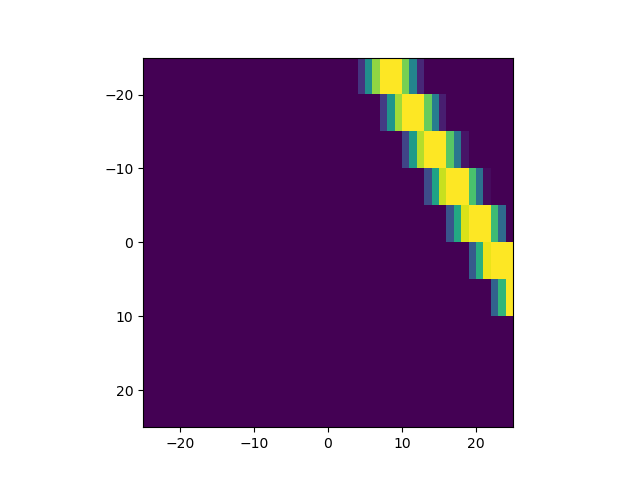

In [135]:
I, labels, extent = sta_validate.parallel_lines_2d(thetas=[np.pi/3], nI=(10,50), dI=(5.0,1.0), period=100, width=8, noise=0.0)
# J, labels, extent = sta_validate.parallel_lines_2d(thetas=[np.pi/3], nI=(100,500), dI=(5.0,1.0), period=10, width=1, noise=0.0)
# K, labels, extent = sta_validate.parallel_lines_2d(thetas=[-np.pi/3], nI=(250,500), dI=(2.0,1.0), period=50, width=4, noise=0.0)
# L, labels, extent = sta_validate.parallel_lines_2d(thetas=[np.pi/2], nI=(250,500), dI=(2.0,1.0), period=50, width=4, noise=0.0)
plt.figure()
plt.imshow(I, extent=extent)
# fig,axs = plt.subplots(2,2)
# axs[0,0].imshow(I, extent=extent)
# axs[0,0].set_title('I')
# axs[1,0].imshow(J,extent=extent)
# axs[1,0].set_title('J')
# axs[0,1].imshow(K, extent=extent)
# axs[0,1].set_title('K')
# axs[1,1].imshow(L,extent=extent)
# axs[1,1].set_title('L')

In [4]:
print(I.shape)

(100, 500)


thetas [-81. -45.  -9.  27.  63.]
shape: (200, 200)


Text(0.5, 1.0, 'mask')

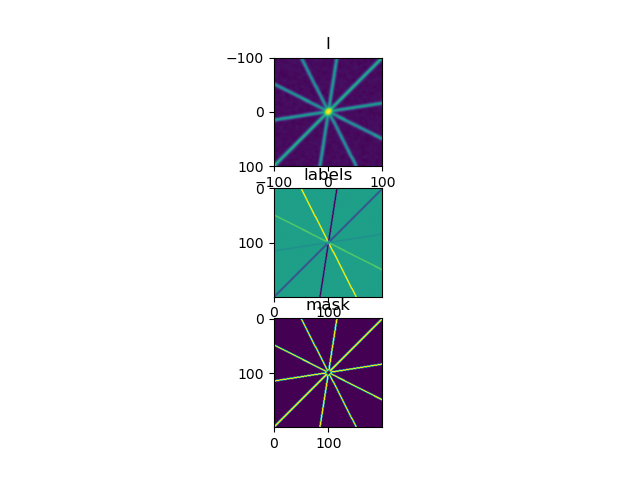

In [38]:
nI=(200,200)
dI=(nI[1]/nI[0],1.0)
# xI = [(np.arange(n) - (n-1)/2)*d for n,d in zip(nI,dI)]
# XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)
start = -np.pi/2+np.pi/20
stop = np.pi/2+np.pi/20
step = (stop-start)/5
thetas = np.arange(start=start, stop=stop, step=step)
print('thetas',thetas*(180/np.pi))
I, mask, labels, extentI = synthetic2d(thetas=thetas, nI=nI, dI=dI, width=2, blur=2.0, noise=0.05, mask_thresh=0.99)
# circle_img, circle_mask, circle_labels, extent_circle = circle(20, nI=nI, dI=dI)
print(f'shape: {I.shape}')
fig,axs = plt.subplots(3)
axs[0,].imshow(I, extent=extentI)
axs[0].set_title('I')
axs[1].imshow(labels)#,extent=extentI)
axs[1].set_title('labels')
axs[2].imshow(mask)
axs[2].set_title('mask')
# axs[0,1].imshow(circle_img,extent=extent_circle)
# axs[0,1].set_title('circle')
# axs[1,1].imshow(circle_labels, extent=extent_circle)
# axs[1,1].set_title('circle labels')

(50, 200)


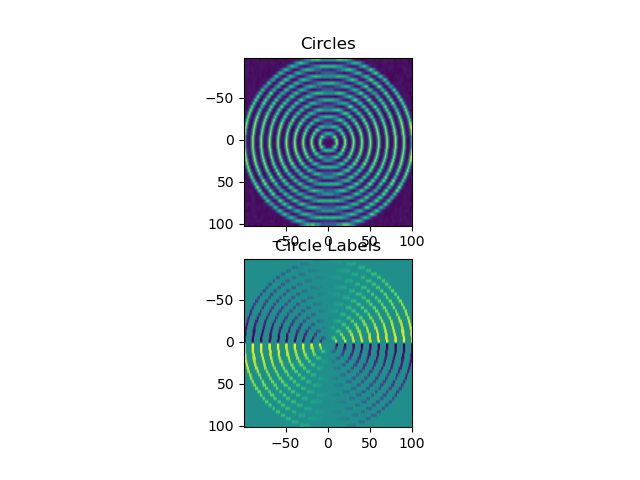

In [70]:
nI=(50,200)
dI=(nI[1]/nI[0],1.0)
step = 10
radii = np.arange(10,100+step,step=step)
circle, circ_mask, circ_labels, circ_extent = synthetic_circle(radius=radii, nI=nI, dI=dI, width=2, blur=1.0) #, mask_thresh=0.2)
fig,axs = plt.subplots(2)
axs[0].imshow(circle, extent=circ_extent)
axs[0].set_title('Circles')
axs[1].imshow(circ_labels,extent=circ_extent)
axs[1].set_title('Circle Labels')
print(circle.shape)


## Anisotropy Corrected Circles

(200, 200)


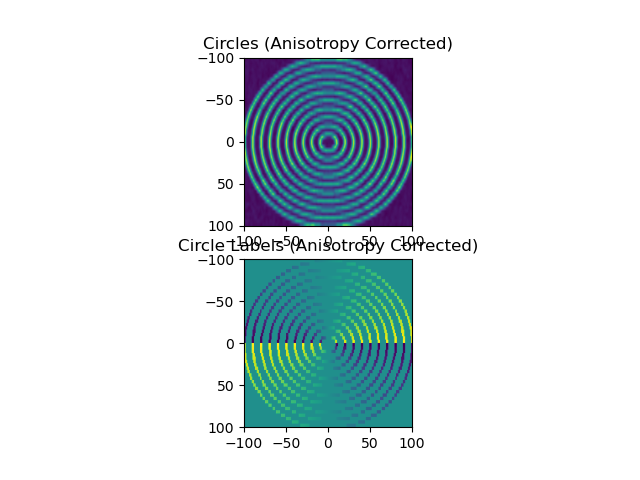

In [71]:
cirImageCorrected, cirMaskCorrected, cirLabelsCorrected, cirExtentCorrected = anisotropy_correction(circle,circ_mask,circ_labels,dI,direction='up')
fig,axs = plt.subplots(2)
axs[0].imshow(cirImageCorrected, extent=cirExtentCorrected)
axs[0].set_title('Circles (Anisotropy Corrected)')
axs[1].imshow(cirLabelsCorrected,extent=cirExtentCorrected)
axs[1].set_title('Circle Labels (Anisotropy Corrected)')
print(cirImageCorrected.shape)

In [53]:
use_sobel = False
derivative_sigma = 6.0
derivative_sigma = [derivative_sigma/dI[0],derivative_sigma/dI[1]]
I = circle

Text(0.5, 1.0, 'Iy')

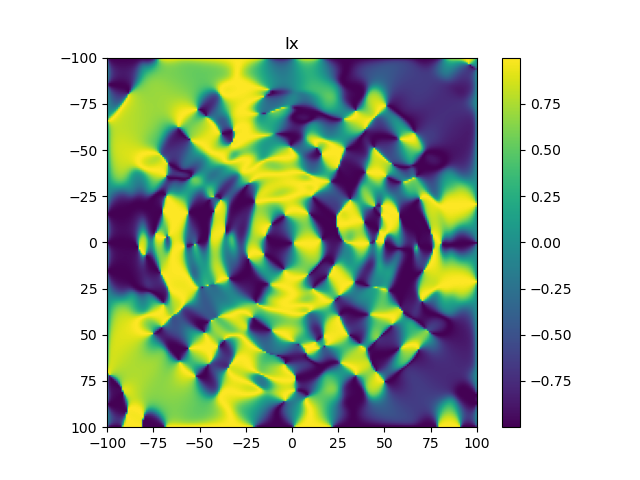

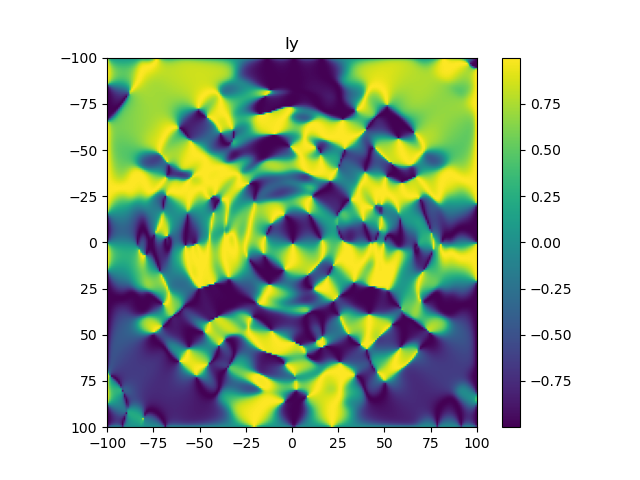

In [54]:
if use_sobel:
    Ix = sobel(I,1)/dI[1]
else:
    # Ix = correlate1d(I,np.array([-1,0,1])/2.0/dI[1],1)
    # Ix = gaussian_filter(Ix,sigma=derivative_sigma)
    Ix = gaussian_filter(I, sigma=derivative_sigma, order=[0,1]) / dI[1]

if use_sobel:
    Iy = sobel(I,0)/dI[0]
else:
    # Iy = correlate1d(I,np.array([-1,0,1])/2.0/dI[0],0)
    # Iy = gaussian_filter(Iy,sigma=derivative_sigma)
    Iy = gaussian_filter(I, sigma=derivative_sigma, order=[1,0]) / dI[0]

norm = np.sqrt(Ix**2 + Iy**2)+np.finfo(float).eps
Ix = Ix/norm
Iy = Iy/norm

fig,ax = plt.subplots()
h = ax.imshow(Ix,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Ix')

fig,ax = plt.subplots()
h = ax.imshow(Iy,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Iy')


Text(0.5, 1.0, 'Iyy')

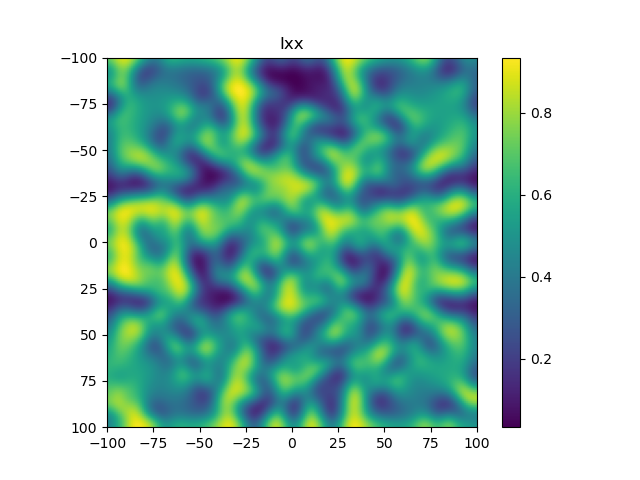

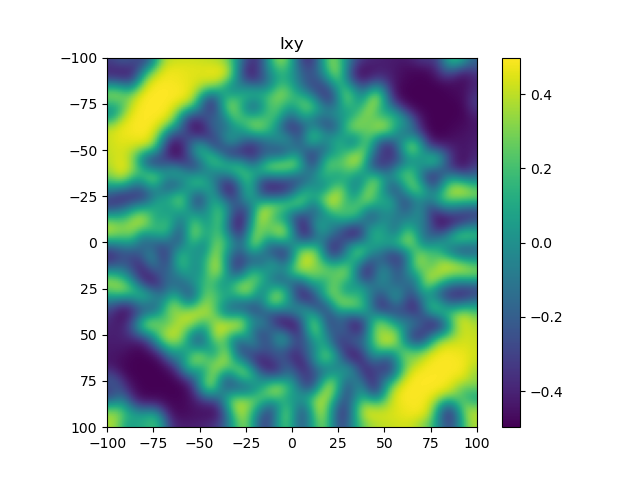

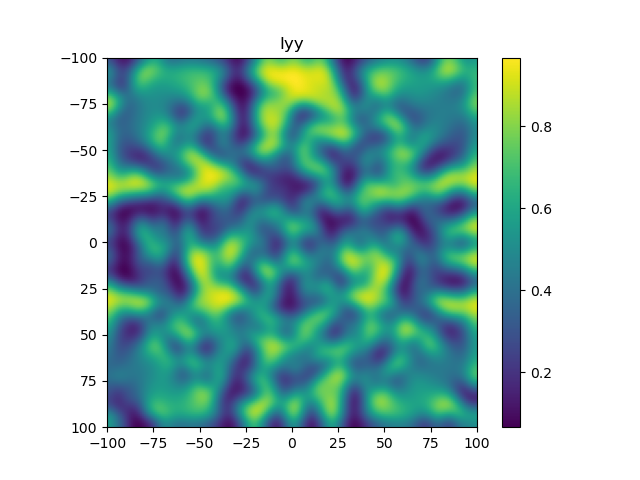

In [55]:

tensor_sigma = 4.0
tensor_sigma = [tensor_sigma/dI[0],tensor_sigma/dI[1]]
Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
fig,ax = plt.subplots()
h = ax.imshow(Ixx,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Ixx')

Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
fig,ax = plt.subplots()
h = ax.imshow(Ixy,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Ixy')

Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
fig,ax = plt.subplots()
h = ax.imshow(Iyy,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Iyy')



/tmp/ipykernel_54299/2781905011.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


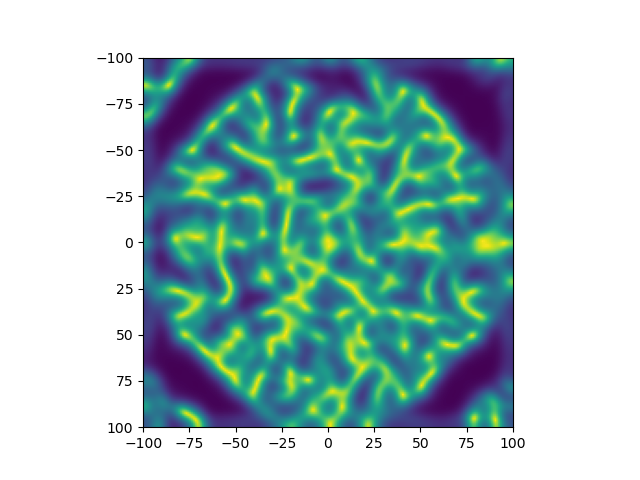

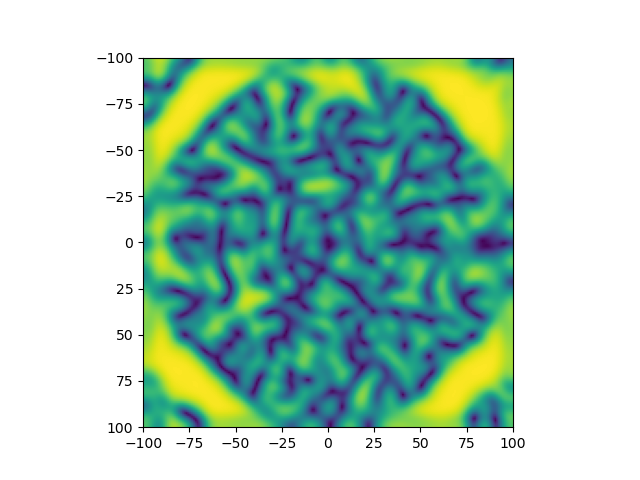

In [56]:
# note S is in XY order, so my glyphs should be too
S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
# S = np.stack([Ixx,Ixy,Ixy,Iyy],-1)
S = S.reshape(S.shape[0],S.shape[1],2,2)
w,v = np.linalg.eigh(S)
# w = 1.0/w
max_each_pixel = False
if max_each_pixel:
    w = w / np.max(w,-1,keepdims=True)
else:
    w = w / np.max(w)
fig,ax = plt.subplots()
ax.imshow(w[...,0],extent=extentI)
fig,ax = plt.subplots()
ax.imshow(w[...,1],extent=extentI)

In [57]:
wd = np.stack((np.sqrt(w[...,0]),np.zeros_like(w[...,0]),np.zeros_like(w[...,0]),np.sqrt(w[...,1])),-1).reshape(w.shape[0],w.shape[1],2,2)

In [58]:
sqrt = v@wd@v.transpose(0,1,3,2)

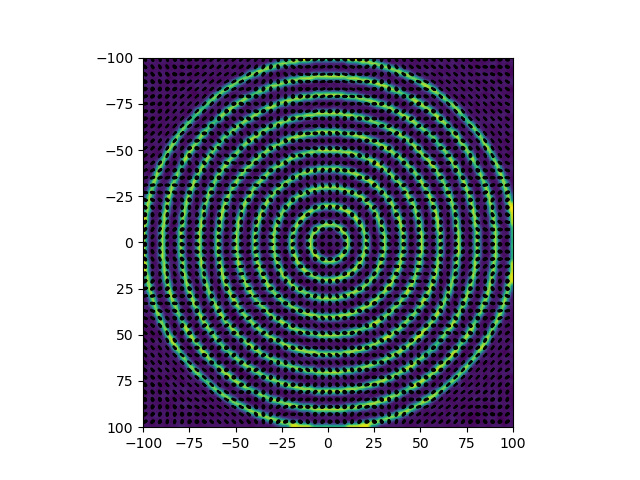

In [59]:
# get a circle
scale = 1.0
# scale = (np.max(w,-1)-np.min(w,-1))[...,None,None]*1.0
# scale = (np.ones_like(w) / dI[::-1])[...,None]*2.5
ntheta = 20
thetas = np.arange(ntheta+1)/ntheta*2.0*np.pi
q = np.stack((np.cos(thetas),np.sin(thetas)),0)

glyphs = sqrt@q
glyphs = glyphs*scale

xI = [(np.arange(n) - (n-1)//2)*d for n,d in zip(nI,dI)]
XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)

glyphs = glyphs + XI[...,::-1,None] # flip row col to xy

down = np.array([4,4])
fig,ax = plt.subplots()
ax.imshow(I,extent=extentI)
for i in range(0,glyphs.shape[0],down[0]):
    for j in range(0,glyphs.shape[1],down[1]):
        ax.plot(glyphs[i,j,0],glyphs[i,j,1],color='k')

mean_error: 41.61194229398773


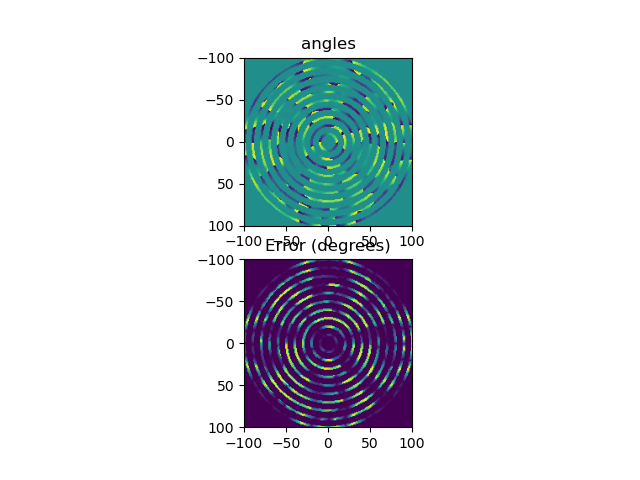

In [60]:
# angles = (histology.angles(S)[0] * np.pi - np.pi/2)*(180/np.pi)
angles = histology.angles(S)[0]*(180/np.pi)
diff = np.abs(angles - circ_labels)
diff = np.where(diff>90.0,np.abs(180-diff),diff)
fig,axs = plt.subplots(2,)
axs[0].imshow(angles*circ_mask, extent=extentI)
axs[0].set_title('angles')
axs[1].imshow(diff*circ_mask,extent=extentI)
axs[1].set_title('Error (degrees)')
mean_error = np.sum(diff*circ_mask)/np.sum(circ_mask)
print(f'mean_error: {mean_error}')

# Test with Radial Line Phantom


### set up parameters

In [61]:
derivative_sigmas = np.arange(start=2.0, stop=22.0,step=2.0)
tensor_sigmas = np.arange(start=2.0, stop=22.0,step=2.0)
anisotropy = [(200,200),(100,200),(67,200),(50,200),(40,200),(34,200),(28,200),(25,200),(22,200),(20,200)]
start = -np.pi/2+np.pi/20
stop = np.pi/2 + np.pi/20
stepsize = (stop-start)/10
line_angles = np.arange(start=start, stop=stop, step=stepsize)

print(derivative_sigmas.shape,
      tensor_sigmas.shape,
      line_angles.shape)

(10,) (10,) (10,)


In [62]:
blur = 2.0

errors = np.zeros((len(line_angles), len(anisotropy), len(derivative_sigmas), len(tensor_sigmas)))

for i,line_angle in enumerate(line_angles):
    for j, nI in enumerate(anisotropy):
        dI = (nI[1]/nI[0], 1.0)
        I, mask,labels,extentI = synthetic2d(thetas=[line_angle], nI=nI, dI=dI, width=1, blur=blur, noise=0.05, mask_thresh=0.99)
        for k,dsig in enumerate(derivative_sigmas):
            for l,tsig in enumerate(tensor_sigmas):
                derivative_sigma = [dsig/dI[0],dsig/dI[1]]
                Ix = gaussian_filter(I, sigma=derivative_sigma, order=[0,1]) / dI[1]
                Iy = gaussian_filter(I, sigma=derivative_sigma, order=[1,0]) / dI[0]
                norm = np.sqrt(Ix**2 + Iy**2)+1e-5
                Ix = Ix/norm
                Iy = Iy/norm
                tensor_sigma = [tsig/dI[0],tsig/dI[1]]
                Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
                Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
                Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
                S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
                S = S.reshape(S.shape[0],S.shape[1],2,2)
                
                angles = histology.angles(S)[0]*(180/np.pi)
                diff = np.abs(angles - labels)
                diff = np.where(diff>90.0,np.abs(180-diff),diff)
                mean_error = np.sum(diff*mask)/np.sum(mask)

                errors[i,j,k,l] = mean_error


In [29]:
errors.shape

(10, 10, 10, 10)

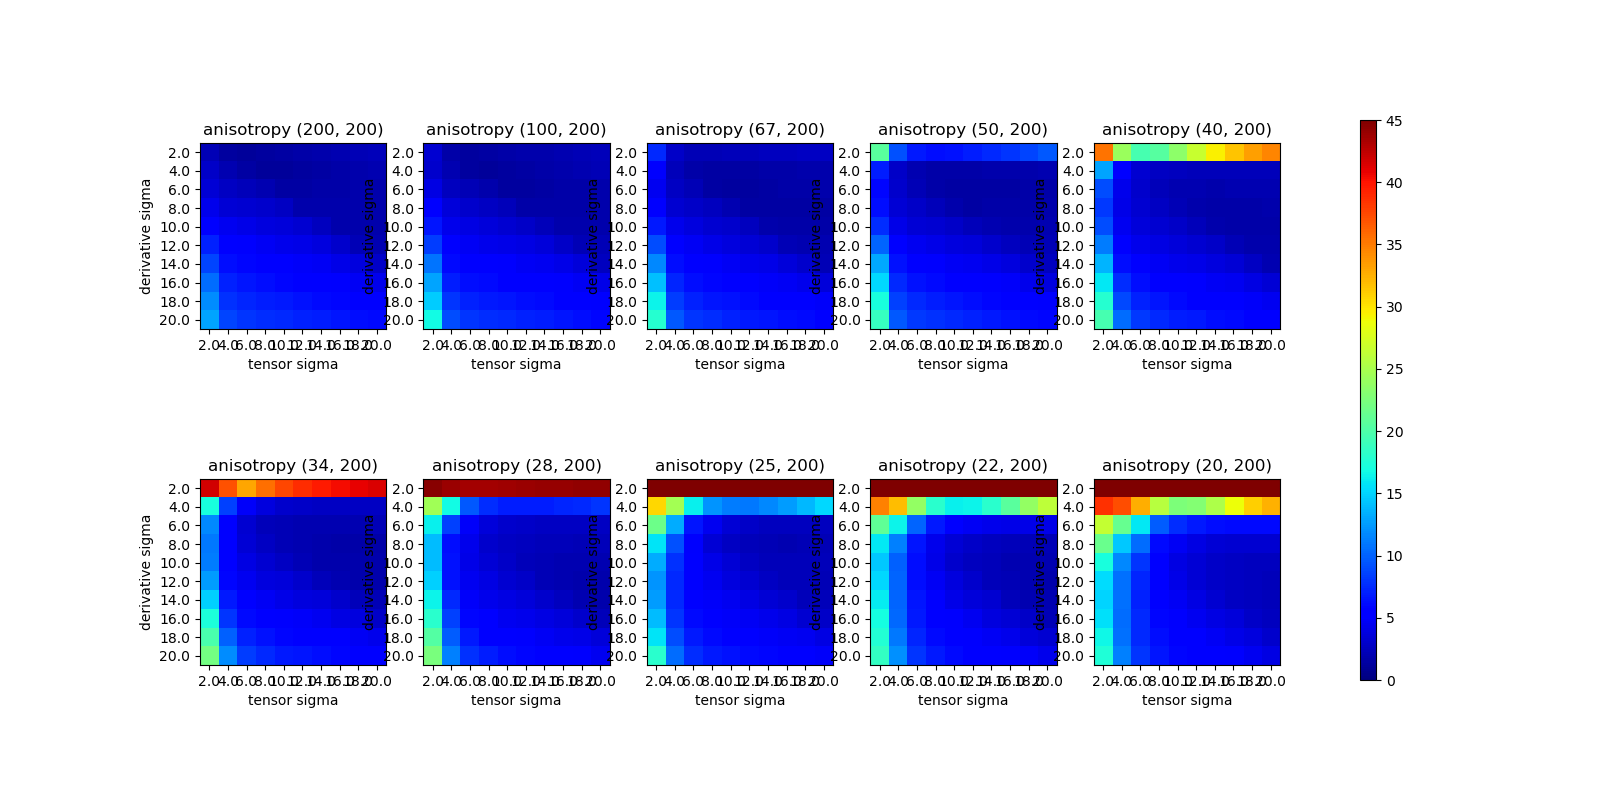

anisotropy=(200, 200); min idx: (0,2)
anisotropy=(100, 200); min idx: (1,3)
anisotropy=(67, 200); min idx: (2,4)
anisotropy=(50, 200); min idx: (2,5)
anisotropy=(40, 200); min idx: (3,7)
anisotropy=(34, 200); min idx: (3,8)
anisotropy=(28, 200); min idx: (5,9)
anisotropy=(25, 200); min idx: (3,7)
anisotropy=(22, 200); min idx: (5,9)
anisotropy=(20, 200); min idx: (5,9)


In [63]:
avg_angle_err = np.sum(errors,axis=0)/errors.shape[0]
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
plt.setp(axs, xticks=range(10),xticklabels=tensor_sigmas, yticks=range(10),yticklabels=derivative_sigmas)
for i in range(10):
    m = i//5
    n = i%5
    ax = axs[m,n]
    # im = ax.imshow(np.sum(errors[i], axis=0)/errors[i].shape[0])
    im = ax.imshow(avg_angle_err[i], vmin=0.0, vmax=45., cmap='jet')
    ax.set_title(f'anisotropy {anisotropy[i]}')
    ax.set_ylabel('derivative sigma')
    # ax.xticks(labels=tensor_sigmas)
    ax.set_xlabel('tensor sigma')
    # ax.yticks(labels=derivative_sigmas)

# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(np.sum(errors,axis=0)/errors.shape[0])
# ax.set_title(f'angular error (degrees)')
# ax.set_xlabel('derivative sigma')
# ax.set_ylabel('tensor sigma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

for a in range(len(anisotropy)):
    # arr = np.sum(errors[a],axis=0)/errors[a].shape[0] # sum over line angles
    arr = avg_angle_err[a]
    min = np.nanargmin(arr)
    if arr.ndim == 4:
        min_i = min//(arr.shape[0]*arr.shape[1]*arr.shape[2])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]))//(arr.shape[1]*arr.shape[2])
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]))//arr.shape[2]
        min_l = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]) - min_k*arr.shape[2])
        print(f'min idx: ({min_i},{min_j},{min_k},{min_l})')
    elif arr.ndim == 3:
        min_i = min//(arr.shape[0]*arr.shape[1])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]))//arr.shape[1]
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]) - min_j*(arr.shape[1]))
        print(f'min idx: ({min_i},{min_j},{min_k})')
    elif arr.ndim == 2:
        min_i = min//(arr.shape[0])
        min_j = (min - min_i*(arr.shape[0]))
        print(f'anisotropy={anisotropy[a]}; min idx: ({min_i},{min_j})')

In [8]:
AI_ratio = [np.round(a[1]/a[0], decimals=2) for a in anisotropy]
print(AI_ratio)

[1.0, 2.0, 2.99, 4.0, 5.0, 5.88, 7.14, 8.0, 9.09, 10.0]


/tmp/ipykernel_998657/1676511327.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(8,8))


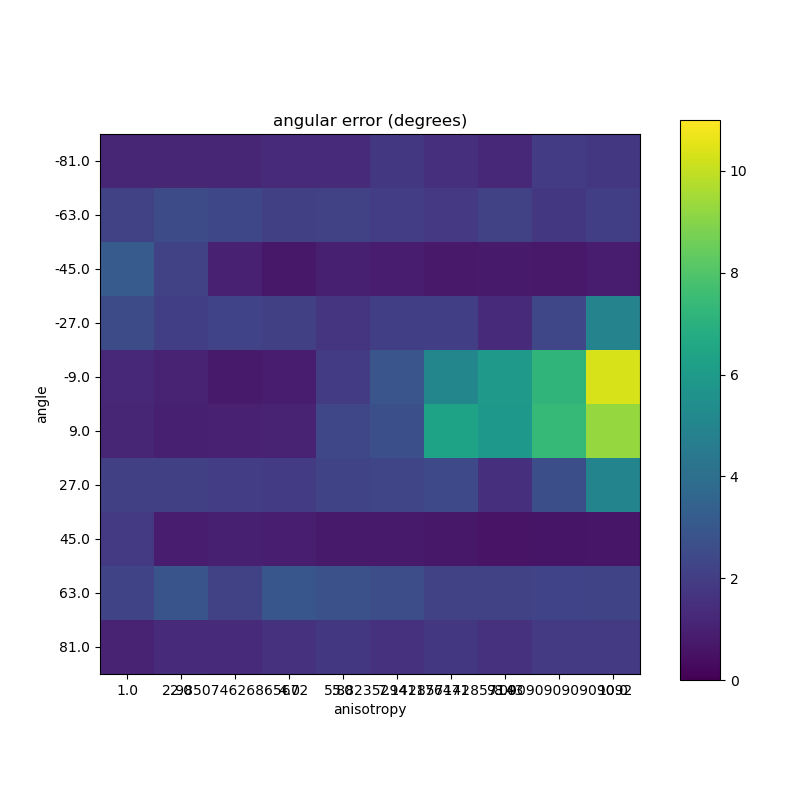

In [35]:
# avg_angle_err = np.sum(errors,axis=0)/errors.shape[0]
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
plt.setp(axs, xticks=range(10),xticklabels=AI_ratio, yticks=range(10), yticklabels=line_angles*(180/np.pi))

im = axs.imshow(errors[...,3,5], vmin=0.0, vmax=11.)
axs.set_title(f'angular error (degrees)')
axs.set_xlabel('anisotropy')
axs.set_ylabel('angle')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


### plot error with anisotropy correction

In [6]:
blur = 2.0

errors_corrected = np.zeros((len(line_angles), len(anisotropy), len(derivative_sigmas), len(tensor_sigmas)))

for i,line_angle in enumerate(line_angles):
    for j, nI in enumerate(anisotropy):
        dI = (nI[1]/nI[0], 1.0)
        I, mask,labels,extentI = synthetic2d(thetas=[line_angle], nI=nI, dI=dI, width=1, blur=blur, noise=0.05, mask_thresh=0.99)
        I_corrected, mask_corrected, labels_corrected, extentI_corrected = anisotropy_correction(I, mask, labels, dI, direction='up', interpolation=cv2.INTER_LINEAR)
        dI_iso = dI[1]
        for k,dsig in enumerate(derivative_sigmas):
            for l,tsig in enumerate(tensor_sigmas):
                derivative_sigma = [dsig/dI_iso,dsig/dI_iso]
                # derivative_sigma = [dsig/dI[0], dsig/dI[1]]
                Ix = gaussian_filter(I_corrected, sigma=derivative_sigma, order=[0,1]) / dI_iso # dI[1]
                Iy = gaussian_filter(I_corrected, sigma=derivative_sigma, order=[1,0]) / dI_iso # dI[0]
                norm = np.sqrt(Ix**2 + Iy**2)
                Ix = Ix/norm
                Iy = Iy/norm
                tensor_sigma = [tsig/dI_iso,tsig/dI_iso]
                # tensor_sigma = [tsig/dI[0], tsig/dI[1]]
                Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
                Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
                Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
                S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
                S = S.reshape(S.shape[0],S.shape[1],2,2)
                
                angles = histology.angles(S)[0]*(180/np.pi)
                diff = np.abs(angles - labels_corrected)
                diff = np.where(diff>90.0,np.abs(180-diff),diff)
                mean_error = np.sum(diff*mask_corrected)/np.sum(mask_corrected)

                errors_corrected[i,j,k,l] = mean_error

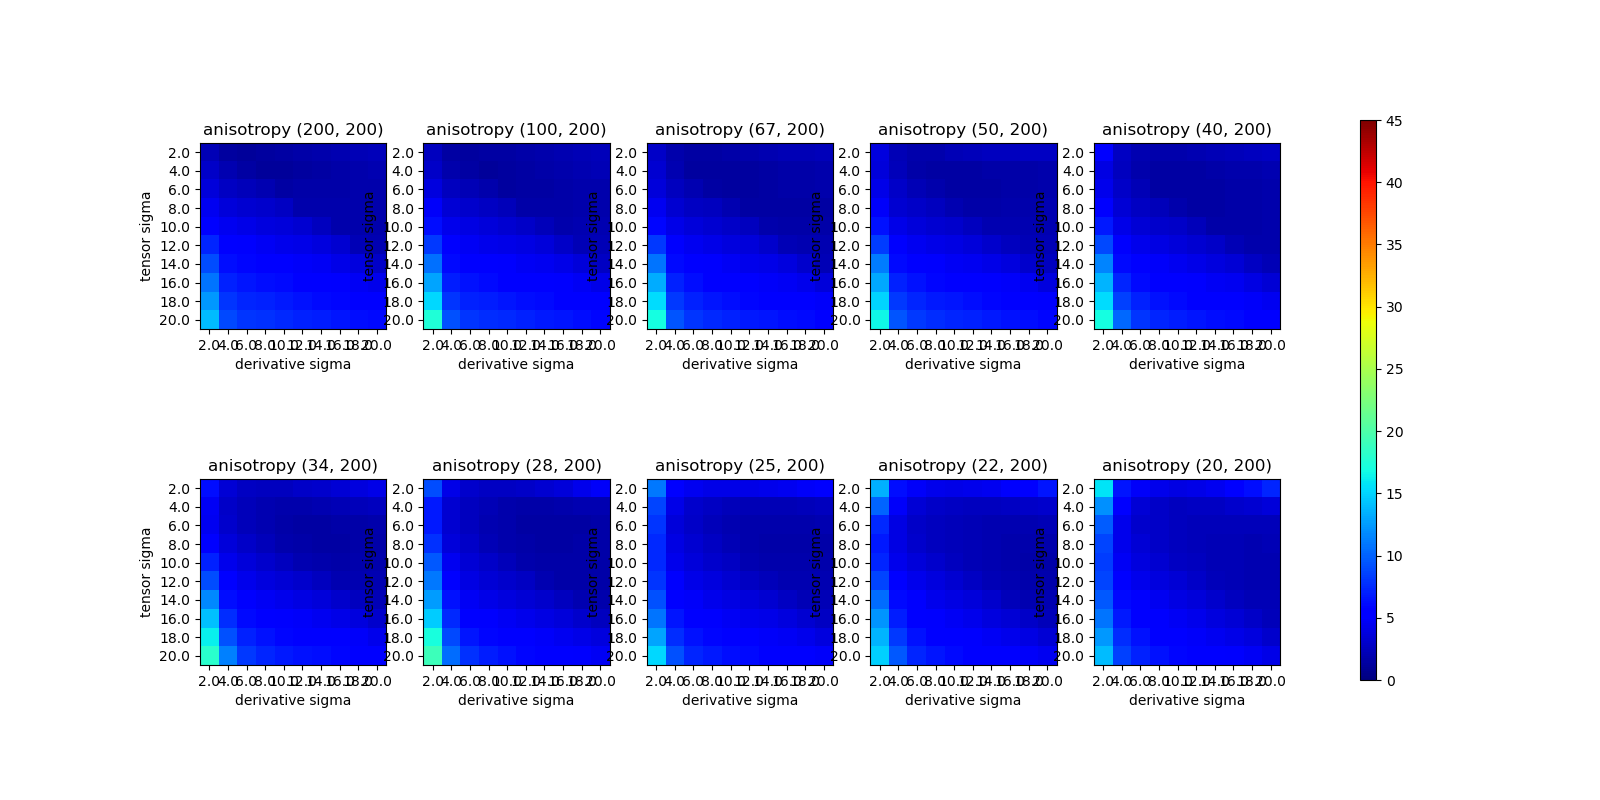

anisotropy=(200, 200); min idx: (0,2)
anisotropy=(100, 200); min idx: (1,3)
anisotropy=(67, 200); min idx: (1,3)
anisotropy=(50, 200); min idx: (1,4)
anisotropy=(40, 200); min idx: (2,5)
anisotropy=(34, 200); min idx: (2,6)
anisotropy=(28, 200); min idx: (2,6)
anisotropy=(25, 200); min idx: (3,7)
anisotropy=(22, 200); min idx: (4,9)
anisotropy=(20, 200); min idx: (4,9)


In [7]:
avg_angle_err = np.sum(errors_corrected,axis=0)/errors_corrected.shape[0]
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
plt.setp(axs, xticks=range(10),xticklabels=tensor_sigmas, yticks=range(10),yticklabels=derivative_sigmas)
for i in range(10):
    m = i//5
    n = i%5
    ax = axs[m,n]
    # im = ax.imshow(np.sum(errors[i], axis=0)/errors[i].shape[0])
    im = ax.imshow(avg_angle_err[i], vmin=0.0, vmax=45., cmap='jet')
    ax.set_title(f'anisotropy {anisotropy[i]}')
    ax.set_ylabel('derivative sigma')
    ax.set_xlabel('tensor sigma')

# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(np.sum(errors,axis=0)/errors.shape[0])
# ax.set_title(f'angular error (degrees)')
# ax.set_xlabel('derivative sigma')
# ax.set_ylabel('tensor sigma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

for a in range(len(anisotropy)):
    # arr = np.sum(errors[a],axis=0)/errors[a].shape[0] # sum over line angles
    arr = avg_angle_err[a]
    min = np.nanargmin(arr)
    if arr.ndim == 4:
        min_i = min//(arr.shape[0]*arr.shape[1]*arr.shape[2])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]))//(arr.shape[1]*arr.shape[2])
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]))//arr.shape[2]
        min_l = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]) - min_k*arr.shape[2])
        print(f'min idx: ({min_i},{min_j},{min_k},{min_l})')
    elif arr.ndim == 3:
        min_i = min//(arr.shape[0]*arr.shape[1])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]))//arr.shape[1]
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]) - min_j*(arr.shape[1]))
        print(f'min idx: ({min_i},{min_j},{min_k})')
    elif arr.ndim == 2:
        min_i = min//(arr.shape[0])
        min_j = (min - min_i*(arr.shape[0]))
        print(f'anisotropy={anisotropy[a]}; min idx: ({min_i},{min_j})')

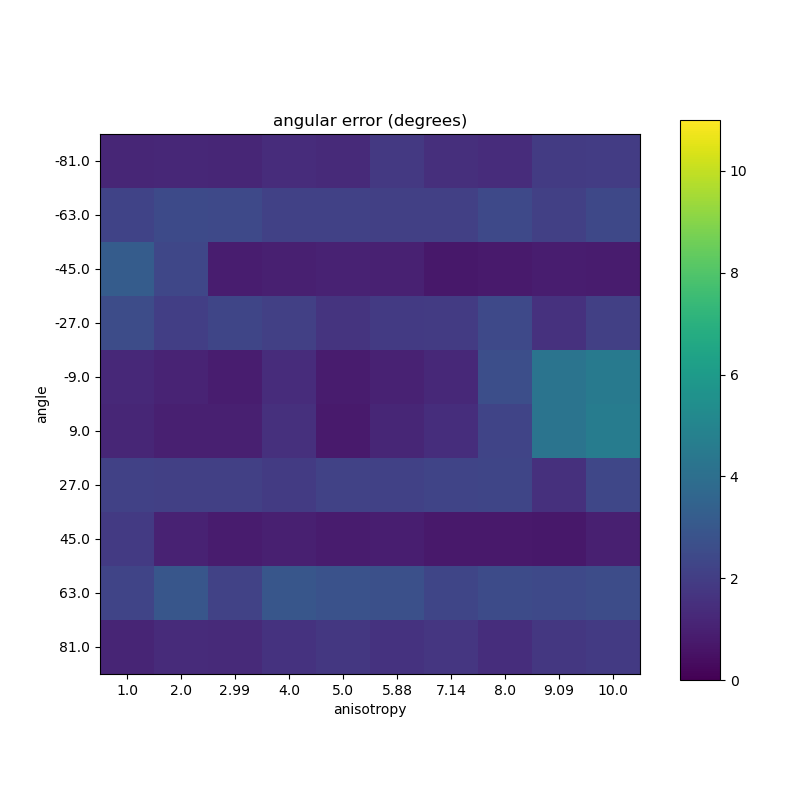

In [10]:
# avg_angle_err = np.sum(errors,axis=0)/errors.shape[0]
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
plt.setp(axs, xticks=range(10),xticklabels=AI_ratio, yticks=range(10), yticklabels=line_angles*(180/np.pi))

im = axs.imshow(errors_corrected[...,3,5], vmin=0.0, vmax=11.)
axs.set_title(f'angular error (degrees)')
axs.set_xlabel('anisotropy')
axs.set_ylabel('angle')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


# Test with Concentric Circles Phantom

In [65]:
derivative_sigmas = np.arange(start=2.0, stop=22.0,step=2.0)
tensor_sigmas = np.arange(start=2.0, stop=22.0,step=2.0)
anisotropy = [(200,200),(100,200),(67,200),(50,200),(40,200),(34,200),(28,200),(25,200),(22,200),(20,200)]
start = 10
stop = 100
step = 10
radii = np.arange(start,stop+step,step=step)

print(derivative_sigmas.shape,
      tensor_sigmas.shape,
      radii.shape,
      len(anisotropy))

(10,) (10,) (10,) 10


In [66]:
blur = 1.0

errors = np.zeros((len(anisotropy), len(derivative_sigmas), len(tensor_sigmas)))

for i, nI in enumerate(anisotropy):
    dI = (nI[1]/nI[0], 1.0)
    I, mask,labels,extentI = synthetic_circle(radius=radii, nI=nI, dI=dI, width=2, blur=blur, noise=0.05)
    for j,dsig in enumerate(derivative_sigmas):
        for k,tsig in enumerate(tensor_sigmas):
            derivative_sigma = [dsig/dI[0],dsig/dI[1]]
            Ix = gaussian_filter(I, sigma=derivative_sigma, order=[0,1]) / dI[1]
            Iy = gaussian_filter(I, sigma=derivative_sigma, order=[1,0]) / dI[0]
            norm = np.sqrt(Ix**2 + Iy**2)+np.finfo(float).eps
            Ix = Ix/norm
            Iy = Iy/norm
            tensor_sigma = [tsig/dI[0],tsig/dI[1]]
            Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
            Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
            Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
            S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
            S = S.reshape(S.shape[0],S.shape[1],2,2)
            
            angles = histology.angles(S)[0]*(180/np.pi)
            diff = np.abs(angles - labels)
            diff = np.where(diff>90.0,np.abs(180-diff),diff)
            mean_error = np.sum(diff*mask)/np.sum(mask)

            errors[i,j,k] = mean_error


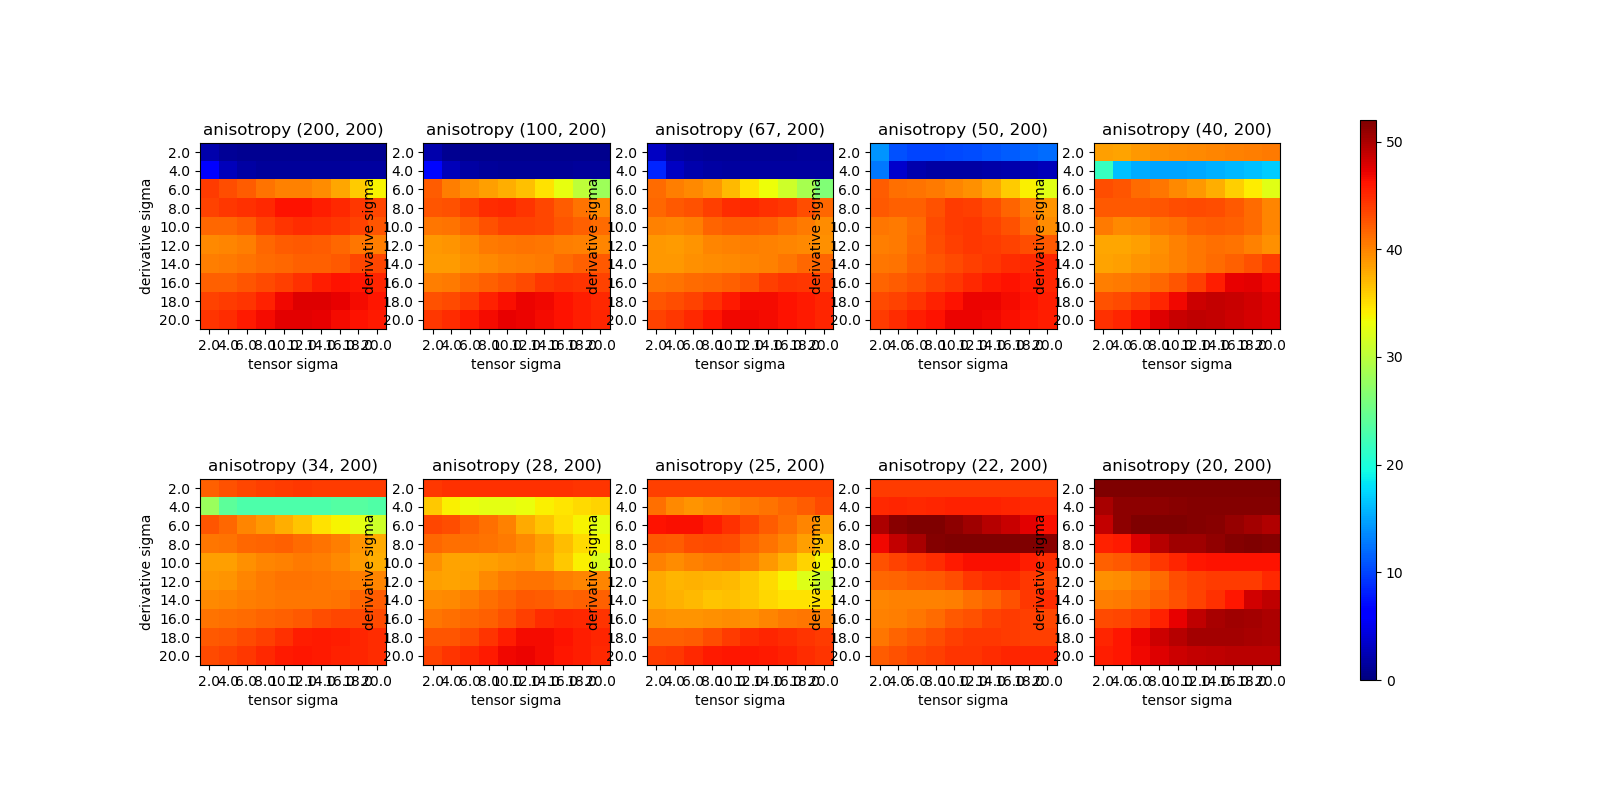

anisotropy=(200, 200); min idx: (0,9)
anisotropy=(100, 200); min idx: (0,5)
anisotropy=(67, 200); min idx: (0,4)
anisotropy=(50, 200); min idx: (1,4)
anisotropy=(40, 200); min idx: (1,4)
anisotropy=(34, 200); min idx: (1,4)
anisotropy=(28, 200); min idx: (4,9)
anisotropy=(25, 200); min idx: (5,9)
anisotropy=(22, 200); min idx: (6,0)
anisotropy=(20, 200); min idx: (5,0)


In [67]:
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
plt.setp(axs, xticks=range(10),xticklabels=tensor_sigmas, yticks=range(10),yticklabels=derivative_sigmas)
for i in range(10):
    m = i//5
    n = i%5
    ax = axs[m,n]
    im = ax.imshow(errors[i],vmin=0.0, vmax=52., cmap='jet')
    # im = ax.imshow(avg_angle_err[i], vmin=0.0, vmax=45., cmap='jet')
    ax.set_title(f'anisotropy {anisotropy[i]}')
    ax.set_ylabel('derivative sigma')
    # ax.xticks(labels=tensor_sigmas)
    ax.set_xlabel('tensor sigma')
    # ax.yticks(labels=derivative_sigmas)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

for a in range(len(anisotropy)):
    # arr = np.sum(errors[a],axis=0)/errors[a].shape[0] # sum over line angles
    arr = errors[a]
    min = np.nanargmin(arr)
    if arr.ndim == 4:
        min_i = min//(arr.shape[0]*arr.shape[1]*arr.shape[2])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]))//(arr.shape[1]*arr.shape[2])
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]))//arr.shape[2]
        min_l = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]) - min_k*arr.shape[2])
        print(f'min idx: ({min_i},{min_j},{min_k},{min_l})')
    elif arr.ndim == 3:
        min_i = min//(arr.shape[0]*arr.shape[1])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]))//arr.shape[1]
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]) - min_j*(arr.shape[1]))
        print(f'min idx: ({min_i},{min_j},{min_k})')
    elif arr.ndim == 2:
        min_i = min//(arr.shape[0])
        min_j = (min - min_i*(arr.shape[0]))
        print(f'anisotropy={anisotropy[a]}; min idx: ({min_i},{min_j})')

In [68]:
blur = 1.0

errors = np.zeros((len(anisotropy), len(derivative_sigmas), len(tensor_sigmas)))

for i, nI in enumerate(anisotropy):
    dI = (nI[1]/nI[0], 1.0)
    I, mask,labels,extentI = synthetic_circle(radius=radii, nI=nI, dI=dI, width=2, blur=blur, noise=0.05)
    I_corrected, mask_corrected, labels_corrected, extentI_corrected = anisotropy_correction(I, mask, labels, dI, direction='up', interpolation=cv2.INTER_LINEAR)
    dI_iso = dI[1]
    for j,dsig in enumerate(derivative_sigmas):
        for k,tsig in enumerate(tensor_sigmas):
            derivative_sigma = [dsig/dI_iso,dsig/dI_iso]
            Ix = gaussian_filter(I_corrected, sigma=derivative_sigma, order=[0,1]) / dI_iso
            Iy = gaussian_filter(I_corrected, sigma=derivative_sigma, order=[1,0]) / dI_iso
            norm = np.sqrt(Ix**2 + Iy**2)+np.finfo(float).eps
            Ix = Ix/norm
            Iy = Iy/norm
            tensor_sigma = [tsig/dI_iso,tsig/dI_iso]
            Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
            Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
            Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
            S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
            S = S.reshape(S.shape[0],S.shape[1],2,2)
            
            angles = histology.angles(S)[0]*(180/np.pi)
            diff = np.abs(angles - labels_corrected)
            diff = np.where(diff>90.0,np.abs(180-diff),diff)
            mean_error = np.sum(diff*mask_corrected)/np.sum(mask_corrected)

            errors[i,j,k] = mean_error

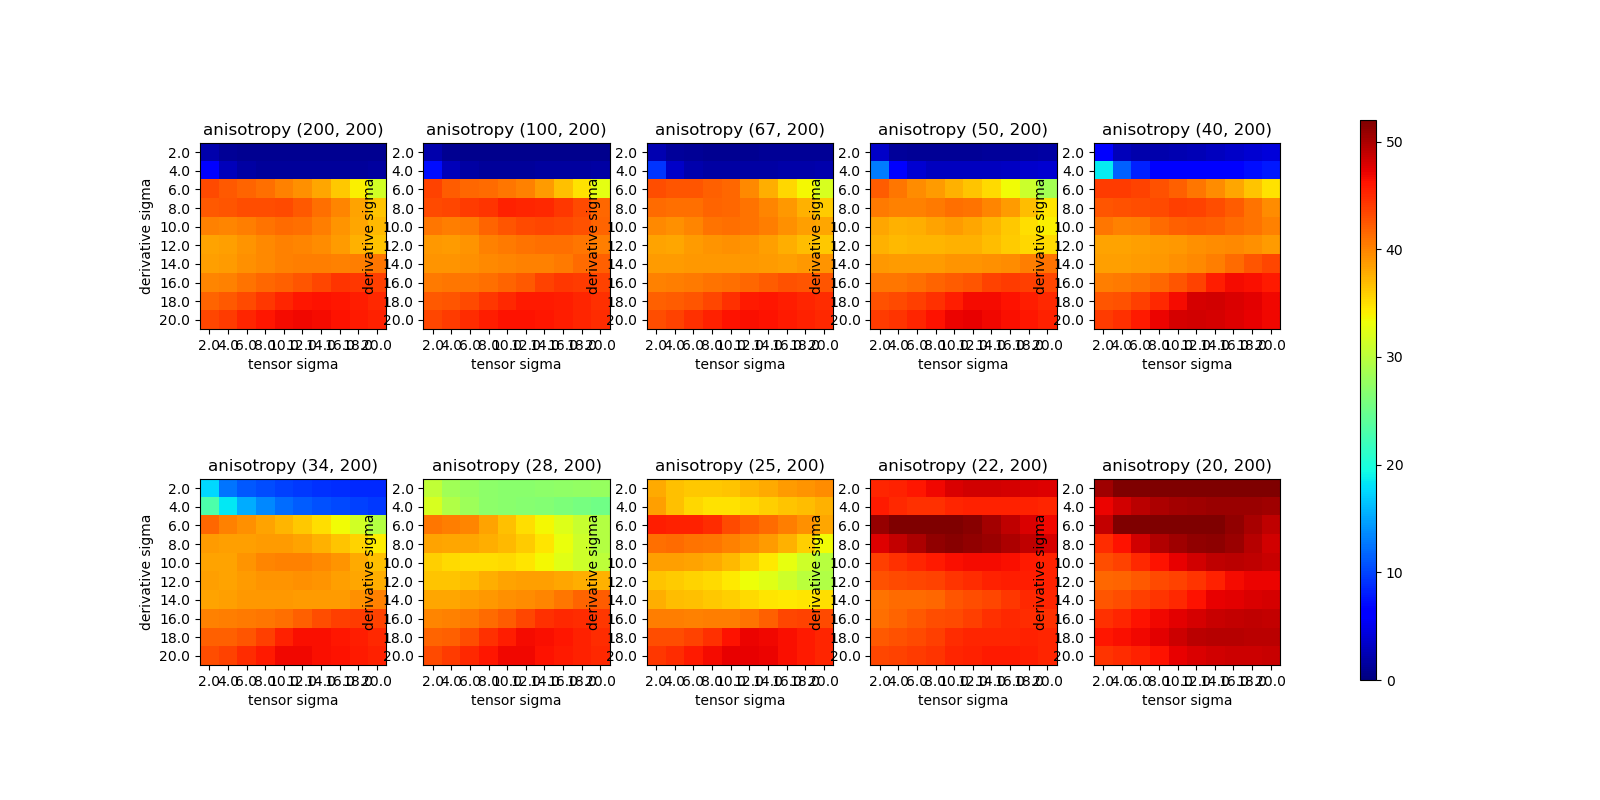

anisotropy=(200, 200); min idx: (0,9)
anisotropy=(100, 200); min idx: (0,9)
anisotropy=(67, 200); min idx: (0,4)
anisotropy=(50, 200); min idx: (0,3)
anisotropy=(40, 200); min idx: (0,2)
anisotropy=(34, 200); min idx: (0,9)
anisotropy=(28, 200); min idx: (1,9)
anisotropy=(25, 200); min idx: (5,9)
anisotropy=(22, 200); min idx: (6,0)
anisotropy=(20, 200); min idx: (5,0)


In [69]:
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
plt.setp(axs, xticks=range(10),xticklabels=tensor_sigmas, yticks=range(10),yticklabels=derivative_sigmas)
for i in range(10):
    m = i//5
    n = i%5
    ax = axs[m,n]
    im = ax.imshow(errors[i],vmin=0.0, vmax=52., cmap='jet')
    # im = ax.imshow(avg_angle_err[i], vmin=0.0, vmax=45., cmap='jet')
    ax.set_title(f'anisotropy {anisotropy[i]}')
    ax.set_ylabel('derivative sigma')
    # ax.xticks(labels=tensor_sigmas)
    ax.set_xlabel('tensor sigma')
    # ax.yticks(labels=derivative_sigmas)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

for a in range(len(anisotropy)):
    # arr = np.sum(errors[a],axis=0)/errors[a].shape[0] # sum over line angles
    arr = errors[a]
    min = np.nanargmin(arr)
    if arr.ndim == 4:
        min_i = min//(arr.shape[0]*arr.shape[1]*arr.shape[2])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]))//(arr.shape[1]*arr.shape[2])
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]))//arr.shape[2]
        min_l = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]) - min_k*arr.shape[2])
        print(f'min idx: ({min_i},{min_j},{min_k},{min_l})')
    elif arr.ndim == 3:
        min_i = min//(arr.shape[0]*arr.shape[1])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]))//arr.shape[1]
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]) - min_j*(arr.shape[1]))
        print(f'min idx: ({min_i},{min_j},{min_k})')
    elif arr.ndim == 2:
        min_i = min//(arr.shape[0])
        min_j = (min - min_i*(arr.shape[0]))
        print(f'anisotropy={anisotropy[a]}; min idx: ({min_i},{min_j})')